In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import torch.nn as nn
from config import *
from load_data import getTrainingSet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class FeedForwardNN(nn.Module):
    def __init__(self, input_size, size_of_hidden_layers, output_size, dropout_rate=0):
        super(FeedForwardNN, self).__init__()
        self.size_of_hidden_layers = size_of_hidden_layers
        self.fc1 = nn.Linear(input_size, size_of_hidden_layers[0])
        self.dropout1 = nn.Dropout(dropout_rate)
        for i in range(1, len(size_of_hidden_layers)):
            setattr(
                self, f'fc{i+1}', nn.Linear(size_of_hidden_layers[i-1], size_of_hidden_layers[i]))
            setattr(
                self, f'dropout{i+1}', nn.Dropout(dropout_rate))

        self.out = nn.Linear(size_of_hidden_layers[-1], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        for i in range(1, len(self.size_of_hidden_layers)):
            fc = getattr(self, f'fc{i+1}')
            dropout = getattr(self, f'dropout{i+1}')
            x = self.relu(fc(x))
            x = dropout(x)
        x = self.out(x)
        return x

In [2]:
def train_model(model, train_loader, epochs, optimizer, loss_function, verbose=False, save_model=False):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        outputs = []
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            # unroll the sequence
            x = x.view(x.size(0), -1)
            output = model.forward(x)
            output = output.squeeze(1)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            if verbose and i % (x.size(0)*10) == 0:
                print(
                    f'Epoch {epoch} Batch {i//x.size(0)} loss: {loss.item()}')
            epoch_losses.append(loss.item())
            outputs.append(output)
        losses.append(np.mean(epoch_losses))
        print(f'Epoch {epoch} loss: {losses[-1]}')
    if save_model:
        torch.save(model.state_dict(), 'trained_models/fnn_trained_model.pth')
    return losses, outputs

In [3]:
from config import *
from load_data import getTrainingSet
from torch.optim import Adam

dataset = getTrainingSet(reshape=False, sequence_length=24)
features = len(dataset.X[0][0])
sequence_length = len(dataset.X[0])
input_size = features * sequence_length
size_of_hidden_layers = FNN_SIZE_OF_HIDDEN_LAYERS
output_size = OUTPUT_SIZE
epochs = FNN_EPOCHS
learning_rate = LEARNING_RATE
l2_regularization_rate = L2_REGULARIZATION_RATE
batch_size = BATCH_SIZE

model = FeedForwardNN(input_size, size_of_hidden_layers, output_size)
loss_function = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=l2_regularization_rate)

In [4]:

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=False)
losses, outputs = train_model(
    model,
    train_dataloader,
    epochs,
    optimizer,
    loss_function,
    verbose=False,
    save_model=True
)


Epoch 0 loss: 0.05889582982633933
Epoch 1 loss: 0.036712448392339544
Epoch 2 loss: 0.026218261345192777
Epoch 3 loss: 0.021926874870899216
Epoch 4 loss: 0.02009983345790576
Epoch 5 loss: 0.01615653896808835
Epoch 6 loss: 0.017753339973240106
Epoch 7 loss: 0.016522202829043906
Epoch 8 loss: 0.01650861631458571
Epoch 9 loss: 0.012895412830403075


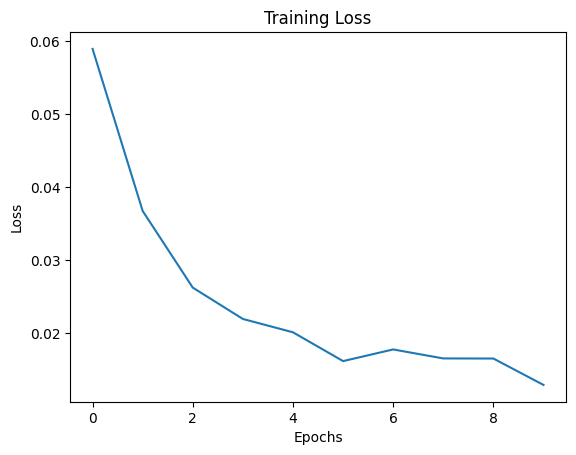

In [5]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [6]:
from load_data import getTestData
model.load_state_dict(torch.load('trained_models/fnn_trained_model.pth'))

model.eval()

data = getTestData()
y_scaler = data[2]

data = (data[0].astype(np.float32), data[1])

In [7]:
import random
def plot_predictions(predictions, targets, y_scaler):
    predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    targets = y_scaler.inverse_transform(targets.reshape(-1, 1))
    plt.plot([i for i in range(23,47)], predictions, label='Predictions')
    
    plt.plot(targets[0:48], label='Targets')
    plt.legend()
    plt.show()

def predict_one_horizon(model, X_test, given_cases,forecast_horizon):
    X_test = X_test.copy()
    predictions = []
    assert len(X_test) == forecast_horizon+given_cases
    with torch.no_grad():
        for i in range(forecast_horizon):
            x = torch.tensor(X_test[i:i+forecast_horizon]).to(device)
            x = x.view(1, -1)
            output = model.forward(x)
            predictions.append(output.item())
            X_test[i+forecast_horizon][-1] = output.item()
    return predictions

def average_error_over_horizons(model, X_test, y_test, forecast_horizon,y_scaler,random_samples=5):
    errors = []
    random.seed(42)
    random_numbers = random.sample(range(len(X_test)-2*forecast_horizon), random_samples)
    
    for i in range(len(X_test)-2*forecast_horizon):
        preds = predict_one_horizon(model, X_test[i:i+2*forecast_horizon], given_cases=forecast_horizon, forecast_horizon=forecast_horizon)
        error = np.mean(np.square(preds-y_test[i+forecast_horizon-1:i+2*forecast_horizon-1]))
        errors.append(error)
        if i in random_numbers:
            plot_predictions(preds, y_test[i:i+2*forecast_horizon], y_scaler)
    return np.mean(errors)


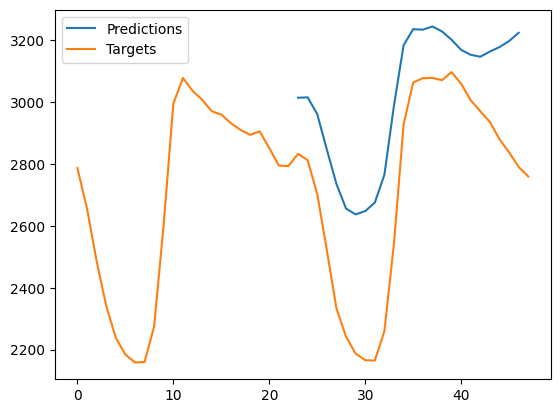

In [8]:
preds=predict_one_horizon(model, data[0][:48], 24, 24)
plot_predictions(preds, data[1], y_scaler)

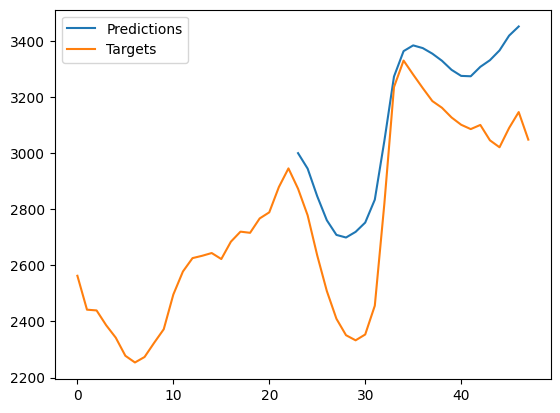

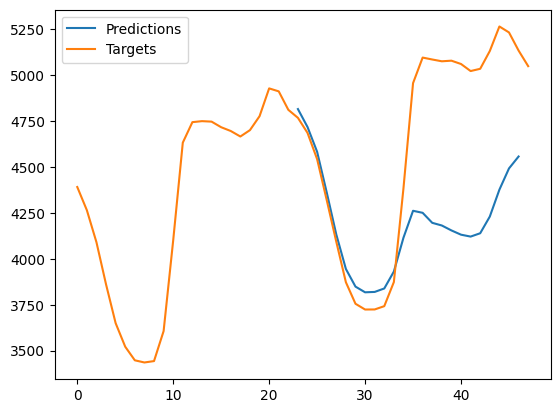

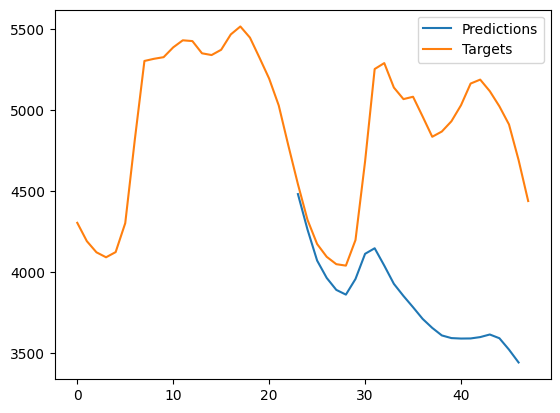

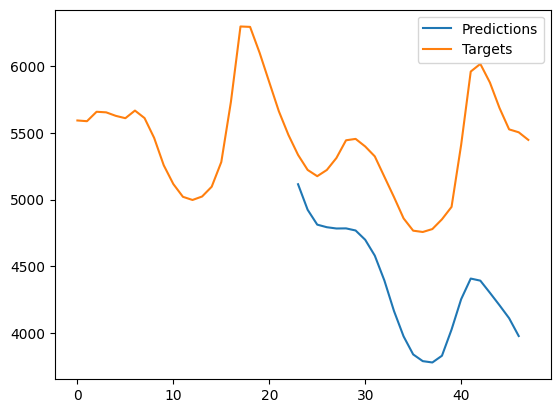

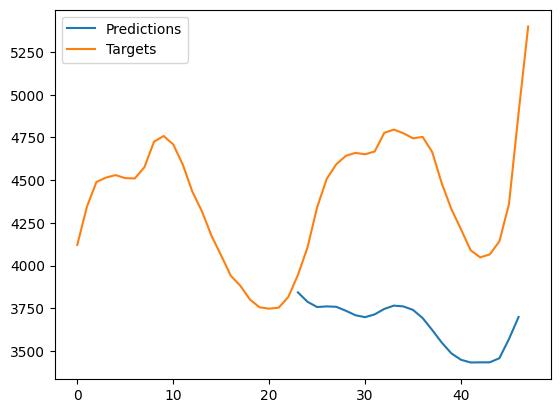

0.21258034362222353


In [9]:
print(average_error_over_horizons(model, data[0], data[1], 24, y_scaler))

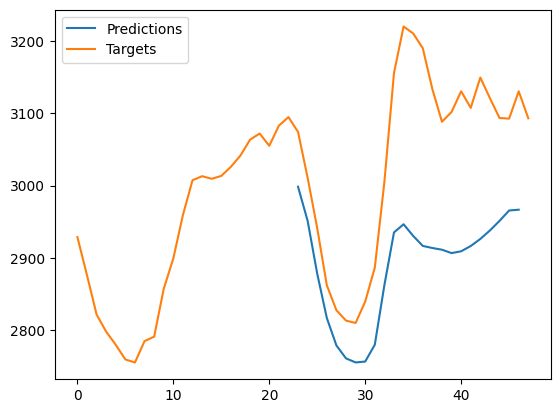

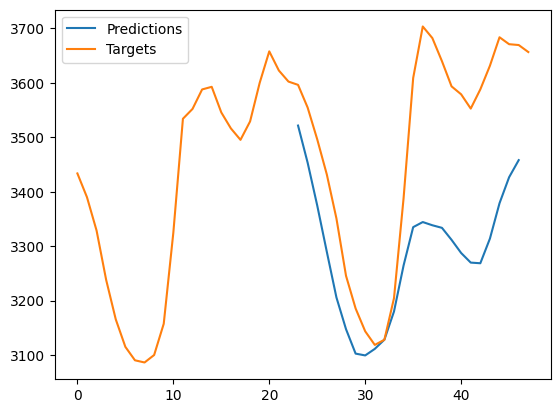

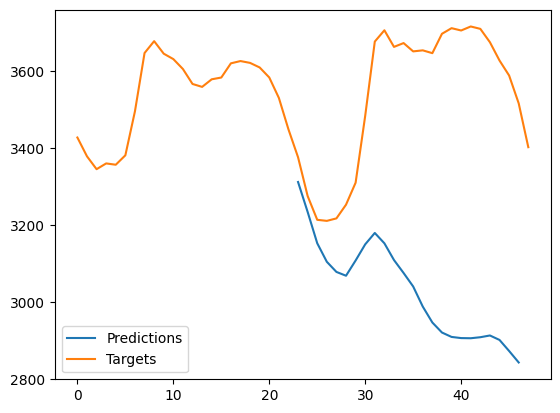

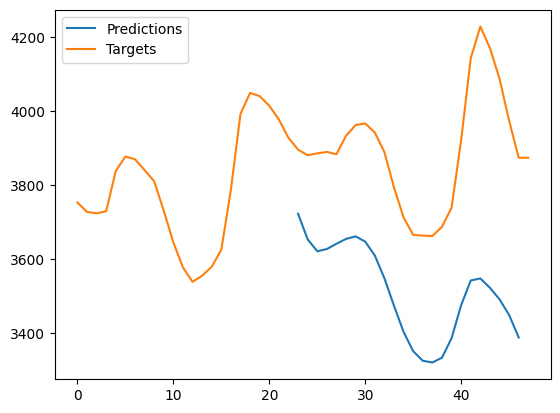

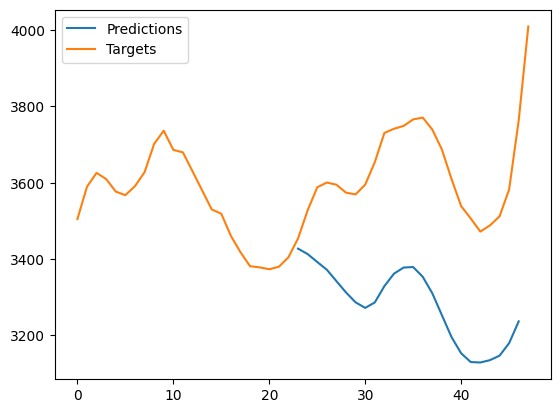

0.3578338440441595


In [10]:
from load_data import getTestData
model.load_state_dict(torch.load('trained_models/fnn_trained_model.pth'))

model.eval()

data = getTestData(region=3)
y_scaler = data[2]
data = (data[0].astype(np.float32), data[1])

# Avg error over no3
print(average_error_over_horizons(model, data[0], data[1], 24,y_scaler))